## Final Project Submission

Please fill out:
* Student name: Robert Sheynin
* Student pace: self paced 
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL: 


# Introduction
This project is an analysis of several datasets that contain information about movies. The goal of this project is to provide insights and business recommendations about what types of movies are currently doing the best at the box office. The analysis will focus on the following: 
- genres
- reviews (rotten tomatoes and imdb)
- ROI and profit

We will also focus on investigating any relationships between the above factors to answer:
- What genres are currently the most popular?
- What genres are the most profitable?
- What genres have the best reviews?
- What is the relationship between reviews and profit?

TODO - maybe include actors, directors, and production companies in the analysis

## Import the necessary libraries

In [80]:
# setup
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
import requests
import statsmodels.api as sm
from sklearn.preprocessing import KBinsDiscretizer



# set pandas options
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.precision', 2)
pd.set_option('display.large_repr', 'truncate')
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.memory_usage', 'deep')

# api key for tmdb
api_key = 'afb631d3b4cac582d777c74aeab9c37e'



## Data Cleaning and Aggregation
- Inspect the various data sources and determine what data is available and how it can be combined to create a single dataset

### Process The Movie Database data
- load the data
- rename columns in preparation for merging
- drop extraneous columns

In [2]:
# read the other files
tmdb_df = pd.read_csv('./data/tmdb.movies.csv')

# rename vote_average to movie_score_tmdb
tmdb_df.rename(columns={'vote_average': 'movie_score_tmdb'}, inplace=True)

# drop columns
tmdb_df.drop(columns=['Unnamed: 0', 'genre_ids', 'original_language', 'release_date', 'vote_count', 'popularity', 'id'], inplace=True)

### Process Movie Gross Data
- Clean up and process the data from [Box Office Mojo]('./data/bom.movie_gross.csv') 
- Aggregate the data with [The Numbers]('./data/tn.movie_budgets.csv') 
- Feature engineer the data to create a new column for ROI (Return on Investment)

In [3]:
# load the revenue data
gross_df = pd.read_csv('./data/bom.movie_gross.csv')
budgets_df = pd.read_csv('./data/tn.movie_budgets.csv')

# rename columns to have a common column name for merging
budgets_df.rename(columns={'movie': 'title', 'domestic_gross': 'domestic_gross_tn'}, inplace=True)
gross_df.rename(columns={ 'domestic_gross': 'domestic_gross_bom'}, inplace=True)

# merge the data frames on the title column
money_df = pd.merge(budgets_df, gross_df, on='title', how='inner')
money_df['domestic_gross_bom'] = money_df['domestic_gross_bom'].astype(float)
money_df['worldwide_gross'] = money_df['worldwide_gross'].str.replace(',', '').str.replace('$', '').astype(float)
money_df['domestic_gross_tn'] = money_df['domestic_gross_tn'].str.replace(',', '').str.replace('$', '').astype(float)
money_df['production_budget'] = money_df['production_budget'].str.replace(',', '').str.replace('$', '').astype(float)

# merge the tmdb data
money_df = pd.merge(money_df, tmdb_df, on='title', how='inner')

# remove duplicates
money_df.drop_duplicates(subset='title', inplace=True)

# normalize the release date 
money_df['release_date'] = pd.to_datetime(money_df['release_date'], format='%b %d, %Y', errors='coerce')


# extract release month and year
money_df['release_month'] = money_df['release_date'].dt.strftime('%b')
money_df['release_year'] = money_df['release_date'].dt.year


# drop columns
# money_df.drop(columns=['domestic_gross_bom', 'domestic_gross_tn', 'foreign_gross', 'id'], inplace=True)

# add columns for profit and roi
money_df['profit'] = money_df['worldwide_gross'] - money_df['production_budget']
money_df['roi'] = (money_df['worldwide_gross'] - money_df['production_budget']) / money_df['production_budget']


money_df.head()

,id,release_date,title,production_budget,domestic_gross_tn,worldwide_gross,studio,domestic_gross_bom,foreign_gross,year,original_title,movie_score_tmdb,release_month,release_year,profit,roi
0,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,4.11e+08,2.41e+08,1.05e+09,BV,2.41e+08,804600000,2011,Pirates of the Caribbean: On Stranger Tides,6.4,May,2011,6.35e+08,1.55
1,4,2015-05-01,Avengers: Age of Ultron,3.31e+08,4.59e+08,1.40e+09,BV,4.59e+08,946400000,2015,Avengers: Age of Ultron,7.3,May,2015,1.07e+09,3.24
2,7,2018-04-27,Avengers: Infinity War,3.00e+08,6.79e+08,2.05e+09,BV,6.79e+08,"1,369.5",2018,Avengers: Infinity War,8.3,Apr,2018,1.75e+09,5.83
3,9,2017-11-17,Justice League,3.00e+08,2.29e+08,6.56e+08,WB,2.29e+08,428900000,2017,Justice League,6.2,Nov,2017,3.56e+08,1.19
5,10,2015-11-06,Spectre,3.00e+08,2.00e+08,8.80e+08,Sony,2.00e+08,680600000,2015,Spectre,6.4,Nov,2015,5.80e+08,1.93


### Process Movie Reviews
Clean up and aggregate the movie [rotten tomato review data]('./data/rt.reviews.tsv') and [rotten tomato review metadata]('./data/rt.movie_info.tsv).
- load the movie data
- impute missing ratings using 'fresh' and 'rotten' ratings as 8 and 2 respectively
- remove reviews with no rating and no fresh or rotten rating
- normalize the ratings to a 0-10 scale
- remove extraneous columns ('critic', 'top_critic', 'publisher', 'date', 'box_office', 'genre', 'director', 'studio')
- remove all attributes except 'id' and 'rating'
    - note that 'review' which contains the review text is not included in the final data but could have been used for sentiment analysis to infer a missing rating as positive or negative
- create a function to query tmdb for movie titles by director and year
- combine the review data with the movie metadata

In [4]:
# load data
reviews_df = pd.read_csv('./data/rt.reviews.tsv', delimiter='\t', encoding='latin1')
movie_info_df = pd.read_csv('./data/rt.movie_info.tsv', delimiter='\t', encoding='latin1')

# drop rows that do not have both a rating and a 'fresh' or 'rotten' value
reviews_df = reviews_df[reviews_df['fresh'].isin(['fresh', 'rotten']) | reviews_df['rating'].notnull()]

# normalize ratings
def convert_rating(rating):
    letter_grade_map = {
        'A+': 10, 'A': 9.5, 'A-': 9,
        'B+': 8.5, 'B': 8, 'B-': 7.5,
        'C+': 7, 'C': 6.5, 'C-': 6,
        'D+': 5.5, 'D': 5, 'D-': 4.5,
        'F': 3
    }
    
    def parse_fraction(fraction_str):
        try:
            if ' ' in fraction_str:
                integer_part, fraction_part = fraction_str.split(' ')
                num, denom = fraction_part.split('/')
                return float(integer_part) + (float(num) / float(denom))
            elif '/' in fraction_str:
                num, denom = fraction_str.split('/')
                return float(num) / float(denom)
            else:
                return float(fraction_str)
        except ValueError:
            print(f'Warning: Could not convert fraction {fraction_str}')
            return None
    
    try:
        if isinstance(rating, str):
            if '/' in rating or ' ' in rating:
                return parse_fraction(rating) * 10
            elif rating in letter_grade_map:
                return letter_grade_map[rating]
            else:
                return None
        else:
            return None
            
    except ValueError:
        print(f'Warning: Could not convert rating {rating}')
        return None


# apply the conversion
reviews_df['rating'] = reviews_df['rating'].apply(convert_rating)

# convert rating to float
reviews_df['rating'] = reviews_df['rating'].astype(float)

# map the rotten and fresh ratings to integers to impute the missing ratings
fresh_rotten_mapping = {
    'rotten': 5,
    'fresh': 8
}

# infer ratings based on 'fresh' and 'rotten' values
reviews_df['inferred_rating'] = reviews_df['fresh'].map(fresh_rotten_mapping)

# if 'review_score' is missing, use the inferred rating
reviews_df['rating'] = reviews_df['rating'].fillna(reviews_df['inferred_rating'])

# drop the 'inferred_rating' column as it was just used for imputation
reviews_df.drop(columns=['inferred_rating'], inplace=True)

# rename the 'rating' column in reviews_df to 'review_score'
reviews_df.rename(columns={'rating': 'review_score'}, inplace=True)

# merge the DataFrames on the 'id' column
rotten_tomato_df = pd.merge(movie_info_df, reviews_df, on='id', how='inner')

# normalize the release date
rotten_tomato_df['theater_date'] = pd.to_datetime(rotten_tomato_df['theater_date'], format='%b %d, %Y', errors='coerce')

# extract release month and year
rotten_tomato_df['month'] = rotten_tomato_df['theater_date'].dt.strftime('%b')
rotten_tomato_df['year'] = rotten_tomato_df['theater_date'].dt.year

# process the genre column
rotten_tomato_df['genre'] = rotten_tomato_df['genre'].str.split('|')
#rotten_tomato_df['genre'] = rotten_tomato_df['genre'].apply(lambda x: [genre.strip().lower() for genre in x] if x is not None else x)

# function to query the TMDb API for a movie's title by director and release date
def search_movie_by_director_release(director_name, release_date):
    # Step 1: Search for the director to get their TMDb ID
    director_search_url = f"https://api.themoviedb.org/3/search/person?api_key={api_key}&query={director_name}"
    director_response = requests.get(director_search_url).json()

    if director_response['results']:
        director_id = director_response['results'][0]['id']
        
        # Step 2: Use the director ID to search for movies
        movie_search_url = f"https://api.themoviedb.org/3/discover/movie?api_key={api_key}&with_people={director_id}&primary_release_year={release_date[:4]}"
        movie_response = requests.get(movie_search_url).json()
        
        if movie_response['results']:
            return movie_response['results'][0]['title']  # Return the first matched title
        else:
            return "No Title Found"
    else:
        return "Director Not Found"

# remove duplicates based on 'id'
rotten_tomato_df.drop_duplicates(subset='id', inplace=True)

# create a new column 'title' by making an API call for each row
rotten_tomato_df['title'] = rotten_tomato_df.apply(
    lambda row: search_movie_by_director_release(row['director'], str(row['theater_date'])), axis=1
)

# drop columns
rotten_tomato_df.drop(columns=['dvd_date', 'date', 'box_office', 'synopsis', 'critic', 'publisher', 'top_critic', 'review'], inplace=True)

rotten_tomato_df.head()

,id,rating,genre,director,writer,theater_date,currency,runtime,studio,review_score,fresh,month,year,title
0,3,R,"[Drama, Science Fiction and Fantasy]",David Cronenberg,David Cronenberg|Don DeLillo,2012-08-17,$,108 minutes,Entertainment One,6.0,fresh,Aug,2012.0,Cosmopolis
163,5,R,"[Drama, Musical and Performing Arts]",Allison Anders,Allison Anders,1996-09-13,NaN,116 minutes,NaN,8.0,fresh,Sep,1996.0,Grace of My Heart
186,6,R,"[Drama, Mystery and Suspense]",Barry Levinson,Paul Attanasio|Michael Crichton,1994-12-09,NaN,128 minutes,NaN,5.0,rotten,Dec,1994.0,Disclosure
243,8,PG,"[Drama, Kids and Family]",Jay Russell,Gail Gilchriest,2000-03-03,NaN,95 minutes,Warner Bros. Pictures,8.0,fresh,Mar,2000.0,No Title Found
318,10,PG-13,[Comedy],Jake Kasdan,Mike White,2002-01-11,$,82 minutes,Paramount Pictures,6.0,fresh,Jan,2002.0,Orange County


In [5]:
## note that we have some missing values.

# print the number of rows that contain 'No Title Found' in the 'title' column as a ratio of the total number of rows
print(rotten_tomato_df[rotten_tomato_df['title'] == 'No Title Found'].shape[0] / rotten_tomato_df.shape[0])
# print the total number of rows
print(rotten_tomato_df.shape[0])

0.1682819383259912
1135


### Process IMDB Data
- load the IMDB data
- query all tables and load them into a data frame
- merge data

In [6]:
# load sql data
conn = sqlite3.connect('./data/im.db')

# load all tables into a dataframe
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
table_names = tables['name'].tolist()
im_df = {table: pd.read_sql_query(f"SELECT * FROM {table};", conn) for table in table_names}

# close connection 
conn.close()

# print the head of each table
for table, df in im_df.items():
    print(f'{table}:\n{df.head()}\n\n')


movie_basics:
    movie_id                    primary_title              original_title  start_year  runtime_minutes                genres
0  tt0063540                        Sunghursh                   Sunghursh        2013            175.0    Action,Crime,Drama
1  tt0066787  One Day Before the Rainy Season             Ashad Ka Ek Din        2019            114.0       Biography,Drama
2  tt0069049       The Other Side of the Wind  The Other Side of the Wind        2018            122.0                 Drama
3  tt0069204                  Sabse Bada Sukh             Sabse Bada Sukh        2018              NaN          Comedy,Drama
4  tt0100275         The Wandering Soap Opera       La Telenovela Errante        2017             80.0  Comedy,Drama,Fantasy


directors:
    movie_id  person_id
0  tt0285252  nm0899854
1  tt0462036  nm1940585
2  tt0835418  nm0151540
3  tt0835418  nm0151540
4  tt0878654  nm0089502


known_for:
   person_id   movie_id
0  nm0061671  tt0837562
1  nm0061671  tt23

In [7]:
# flatten the imdb dataframe
movie_df = im_df['movie_basics']

# merge movie_ratings
movie_df = pd.merge(movie_df, im_df['movie_ratings'], on='movie_id', how='left')

# mark missing values as unknown
movie_df['genres'] = movie_df['genres'].fillna('Unknown')

# split genres into a list
movie_df['genres'] = movie_df['genres'].str.split(',')

# normalize genres
movie_df['genres'] = movie_df['genres'].apply(lambda x: [genre.strip().lower() for genre in x])



# merge directors
df = pd.merge(df, im_df['directors'], on='movie_id', how='left')

# merge writers
# df = pd.merge(df, im_df['writers'], on='movie_id', how='left')

# # merge with principals
# df = pd.merge(df, im_df['principals'], on='movie_id', how='left')

# # merge with writers
# df = pd.merge(df, im_df['writers'], on='movie_id', how='left')

# # merge with persons
# df = pd.merge(df, im_df['persons'], on='person_id', how='left')

movie_df.head(10)




,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"[action, crime, drama]",7.0,77.0
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"[biography, drama]",7.2,43.0
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,[drama],6.9,4517.0
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"[comedy, drama]",6.1,13.0
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"[comedy, drama, fantasy]",6.5,119.0
5,tt0111414,A Thin Life,A Thin Life,2018,75.0,[comedy],NaN,NaN
6,tt0112502,Bigfoot,Bigfoot,2017,NaN,"[horror, thriller]",4.1,32.0
7,tt0137204,Joe Finds Grace,Joe Finds Grace,2017,83.0,"[adventure, animation, comedy]",8.1,263.0
8,tt0139613,O Silêncio,O Silêncio,2012,NaN,"[documentary, history]",NaN,NaN
9,tt0144449,Nema aviona za Zagreb,Nema aviona za Zagreb,2012,82.0,[biography],NaN,NaN


### Combine the data
- combine the data from the movie database, movie gross, movie reviews, and IMDB data into a single data frame
- save the data to derrived_data.csv

In [8]:
movie_df.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"[action, crime, drama]",7.0,77.0
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"[biography, drama]",7.2,43.0
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,[drama],6.9,4517.0
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"[comedy, drama]",6.1,13.0
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"[comedy, drama, fantasy]",6.5,119.0


In [9]:
rotten_tomato_df.head()

,id,rating,genre,director,writer,theater_date,currency,runtime,studio,review_score,fresh,month,year,title
0,3,R,"[Drama, Science Fiction and Fantasy]",David Cronenberg,David Cronenberg|Don DeLillo,2012-08-17,$,108 minutes,Entertainment One,6.0,fresh,Aug,2012.0,Cosmopolis
163,5,R,"[Drama, Musical and Performing Arts]",Allison Anders,Allison Anders,1996-09-13,NaN,116 minutes,NaN,8.0,fresh,Sep,1996.0,Grace of My Heart
186,6,R,"[Drama, Mystery and Suspense]",Barry Levinson,Paul Attanasio|Michael Crichton,1994-12-09,NaN,128 minutes,NaN,5.0,rotten,Dec,1994.0,Disclosure
243,8,PG,"[Drama, Kids and Family]",Jay Russell,Gail Gilchriest,2000-03-03,NaN,95 minutes,Warner Bros. Pictures,8.0,fresh,Mar,2000.0,No Title Found
318,10,PG-13,[Comedy],Jake Kasdan,Mike White,2002-01-11,$,82 minutes,Paramount Pictures,6.0,fresh,Jan,2002.0,Orange County


In [10]:
money_df.head()

,id,release_date,title,production_budget,domestic_gross_tn,worldwide_gross,studio,domestic_gross_bom,foreign_gross,year,original_title,movie_score_tmdb,release_month,release_year,profit,roi
0,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,4.11e+08,2.41e+08,1.05e+09,BV,2.41e+08,804600000,2011,Pirates of the Caribbean: On Stranger Tides,6.4,May,2011,6.35e+08,1.55
1,4,2015-05-01,Avengers: Age of Ultron,3.31e+08,4.59e+08,1.40e+09,BV,4.59e+08,946400000,2015,Avengers: Age of Ultron,7.3,May,2015,1.07e+09,3.24
2,7,2018-04-27,Avengers: Infinity War,3.00e+08,6.79e+08,2.05e+09,BV,6.79e+08,"1,369.5",2018,Avengers: Infinity War,8.3,Apr,2018,1.75e+09,5.83
3,9,2017-11-17,Justice League,3.00e+08,2.29e+08,6.56e+08,WB,2.29e+08,428900000,2017,Justice League,6.2,Nov,2017,3.56e+08,1.19
5,10,2015-11-06,Spectre,3.00e+08,2.00e+08,8.80e+08,Sony,2.00e+08,680600000,2015,Spectre,6.4,Nov,2015,5.80e+08,1.93


In [19]:
# merge movie_df with money_df on 'title' and either 'primary_title' or 'original_title'
merged_df_primary = pd.merge(money_df, movie_df, left_on='title', right_on='primary_title', how='left')

# for rows where primary_title didn't match, try merging with original_title
no_match_primary = merged_df_primary[merged_df_primary['primary_title'].isna()]
matched_original = pd.merge(no_match_primary.drop(columns=movie_df.columns.difference(['movie_id', 'original_title'])), 
                            movie_df, left_on='title', right_on='original_title', how='left')

# combine the results
final_movie_money_df = pd.concat([merged_df_primary[~merged_df_primary['primary_title'].isna()], matched_original])

# merge the combined DataFrame with rotten_tomato_df on 'title'
final_combined_df = pd.merge(final_movie_money_df, rotten_tomato_df, on='title', how='left')

# rename the 'averagerating' column to 'rating_imdb'
final_combined_df.rename(columns={'averagerating': 'rating_imdb'}, inplace=True)

# rename the 'review_score' column to 'rating_rotten_tomato'
final_combined_df.rename(columns={'review_score': 'rating_rotten_tomato'}, inplace=True)

# rename the 'movie_score_tmdb' column to 'rating_tmdb'
final_combined_df.rename(columns={'movie_score_tmdb': 'rating_tmdb'}, inplace=True)

# create a new column 'rating' that is the average of the 'rating_imdb', 'rating_rotten_tomato', and 'rating_tmdb' columns
final_combined_df['rating'] = final_combined_df[['rating_imdb', 'rating_rotten_tomato', 'rating_tmdb']].mean(axis=1)

# automatically combine columns with suffixes '_x' and '_y'
for col in final_combined_df.columns:
    if '_x' in col:
        base_col_name = col.rstrip('_x')
        if base_col_name in final_combined_df.columns:
            final_combined_df[base_col_name] = final_combined_df[base_col_name].combine_first(final_combined_df[col])
        else:
            final_combined_df[base_col_name] = final_combined_df[col]
        final_combined_df.drop(columns=[col], inplace=True)
    elif '_y' in col:
        base_col_name = col.rstrip('_y')
        if base_col_name in final_combined_df.columns:
            final_combined_df[base_col_name] = final_combined_df[base_col_name].combine_first(final_combined_df[col])
        else:
            final_combined_df[base_col_name] = final_combined_df[col]
        final_combined_df.drop(columns=[col], inplace=True)

# convert list-type columns to a hashable type (like a string or tuple)
for col in final_combined_df.columns:
    if final_combined_df[col].apply(lambda x: isinstance(x, list)).any():
        final_combined_df[col] = final_combined_df[col].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)


# drop duplicates
final_combined_df.drop_duplicates(inplace=True)

# drop empty/unused columns
final_combined_df.drop(columns=['theater_date', 'currency', 'fresh', 
                                'genre', 'runtime', 'director', 
                                'writer', 'runtime', 'month'
                                ], inplace=True)

# save the DataFrame to a CSV file
final_combined_df.to_csv('./data/derrived_data.csv', index=False)

/var/folders/zp/h7t69w7n1jvg_7vxjttlw77c0000gn/T/ipykernel_47396/2004243597.py:39: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  final_combined_df[base_col_name] = final_combined_df[base_col_name].combine_first(final_combined_df[col])
/var/folders/zp/h7t69w7n1jvg_7vxjttlw77c0000gn/T/ipykernel_47396/2004243597.py:39: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  final_combined_df[base_col_name] = final_combined_df[base_col_name].combine_first(final_combined_df[col])


In [152]:
df = pd.read_csv('./data/derrived_data.csv')



# drop the third genre value for each row
df['genres'] = df['genres'].apply(lambda x: x.split(', ')[:2] if isinstance(x, str) else x)

df.drop(columns=[ 'original_title', 'primary_title', 'domestic_gross_tn', 'worldwide_gross', 
                 'domestic_gross_bom', 'foreign_gross', 'numvotes', 'id', 'rating_rotten_tomato', 
                 'rating_tmdb', 'rating_imdb', #'rounded_rating', 'budget_bin' 
                 ], inplace=True)
df.head()


,release_date,title,production_budget,release_month,profit,roi,movie_id,runtime_minutes,genres,rating,studio,year
0,2011-05-20,Pirates of the Caribbean: On Stranger Tides,4.11e+08,May,6.35e+08,1.55,tt1298650,136.0,"[action, adventure]",6.50,BV,2011
1,2015-05-01,Avengers: Age of Ultron,3.31e+08,May,1.07e+09,3.24,tt2395427,141.0,"[action, adventure]",7.30,BV,2015
2,2018-04-27,Avengers: Infinity War,3.00e+08,Apr,1.75e+09,5.83,tt4154756,149.0,"[action, adventure]",8.40,BV,2018
3,2017-11-17,Justice League,3.00e+08,Nov,3.56e+08,1.19,tt0974015,120.0,"[action, adventure]",6.35,WB,2017
4,2015-11-06,Spectre,3.00e+08,Nov,5.80e+08,1.93,tt2379713,148.0,"[action, adventure]",6.60,Sony,2015


## Exploratory Data Analysis

### Gross by Month

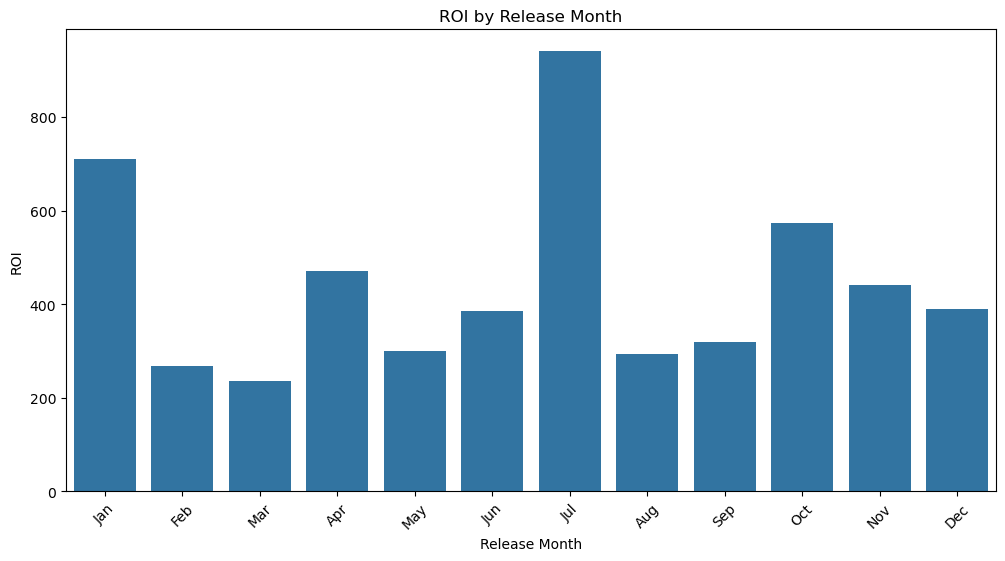

In [153]:
# group by release month and calculate the sum of gross for each month
monthly_gross = df.groupby('release_month')['roi'].sum().reset_index()

# sort the DataFrame by the month order
monthly_gross['release_month'] = pd.Categorical(monthly_gross['release_month'], categories=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], ordered=True)
monthly_gross = monthly_gross.sort_values('release_month')

# create a bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='release_month', y='roi', data=monthly_gross)
plt.title('ROI by Release Month')
plt.xlabel('Release Month')
plt.ylabel('ROI')
plt.xticks(rotation=45)
plt.show()

#### Findings
- The highest grossing months are June and November

### ROI by Month

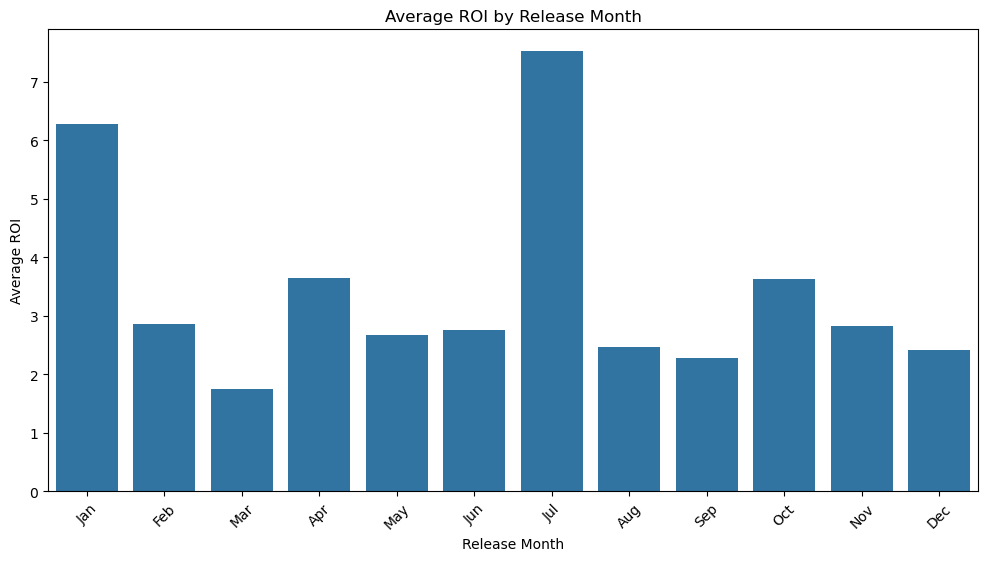

In [154]:
# group by release month and calculate the mean ROI for each month
monthly_roi = df.groupby('release_month')['roi'].mean().reset_index()

# sort the DataFrame by the month order
monthly_roi['release_month'] = pd.Categorical(monthly_roi['release_month'], categories=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], ordered=True)
monthly_roi = monthly_roi.sort_values('release_month')

# create a bar chart for ROI
plt.figure(figsize=(12, 6))
sns.barplot(x='release_month', y='roi', data=monthly_roi)
plt.title('Average ROI by Release Month')
plt.xlabel('Release Month')
plt.ylabel('Average ROI')
plt.xticks(rotation=45)
plt.show()

#### Findings
- The highest ROI months are January and July

### Reviews by Month

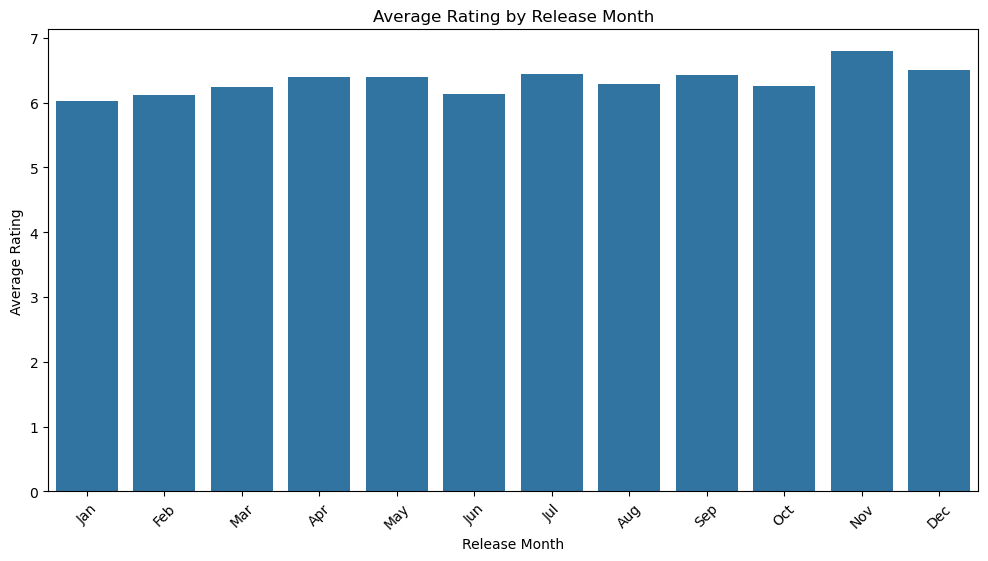

In [155]:
# group by release month and calculate the average rating for each month
monthly_rating = df.groupby('release_month')['rating'].mean().reset_index()

# sort the DataFrame by the month order
monthly_rating['release_month'] = pd.Categorical(monthly_rating['release_month'], categories=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], ordered=True)
monthly_rating = monthly_rating.sort_values('release_month')

# create a bar chart for average rating
plt.figure(figsize=(12, 6))
sns.barplot(x='release_month', y='rating', data=monthly_rating)
plt.title('Average Rating by Release Month')
plt.xlabel('Release Month')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.show()

#### Findings
- There is no clear pattern in the number of reviews by month

### Gross over the years

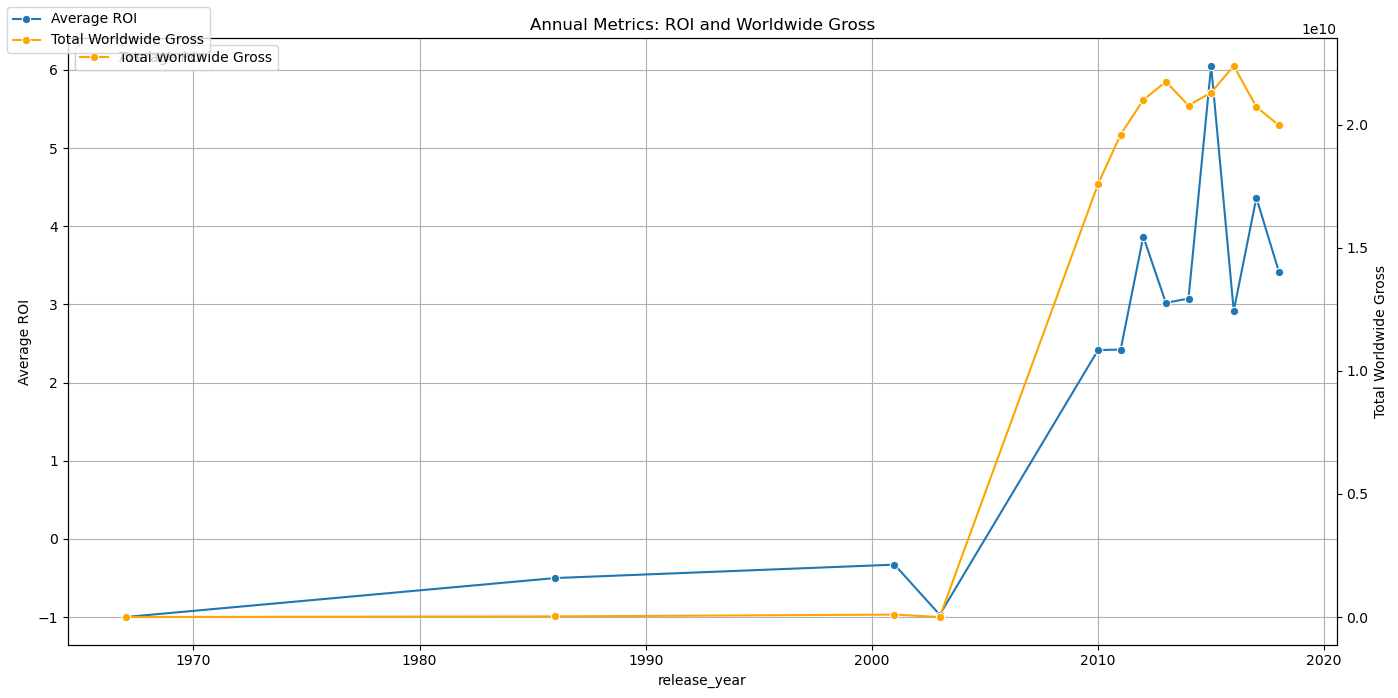

In [156]:
# group by release year and calculate the mean ROI and total worldwide gross for each year
annual_metrics = money_df.groupby('release_year').agg({'roi': 'mean', 'worldwide_gross': 'sum'}).reset_index()

# create a line chart
fig, ax1 = plt.subplots(figsize=(14, 7))

# plot ROI
sns.lineplot(x='release_year', y='roi', data=annual_metrics, marker='o', ax=ax1, label='Average ROI')
ax1.set_ylabel('Average ROI')
ax1.set_title('Annual Metrics: ROI and Worldwide Gross')
ax1.grid(True)

# create a secondary y-axis to plot Worldwide Gross
ax2 = ax1.twinx()
sns.lineplot(x='release_year', y='worldwide_gross', data=annual_metrics, marker='o', ax=ax2, label='Total Worldwide Gross', color='orange')
ax2.set_ylabel('Total Worldwide Gross')

# customize the plot
fig.tight_layout()
fig.legend(loc='upper left')
plt.xticks(rotation=45)

plt.show()

In [157]:
# Group by release year and calculate the mean ROI and total worldwide gross for each year
annual_metrics = money_df.groupby('release_year').agg({'roi': 'mean', 'worldwide_gross': 'sum'}).reset_index()

# Create traces
trace1 = go.Scatter(x=annual_metrics['release_year'], y=annual_metrics['roi'], mode='lines+markers', name='Average ROI')
trace2 = go.Scatter(x=annual_metrics['release_year'], y=annual_metrics['worldwide_gross'], mode='lines+markers', name='Total Worldwide Gross', yaxis='y2')

# Create layout with secondary y-axis
layout = go.Layout(
    title='Annual Metrics: ROI and Worldwide Gross',
    xaxis=dict(title='Release Year'),
    yaxis=dict(title='Average ROI'),
    yaxis2=dict(title='Total Worldwide Gross', overlaying='y', side='right'),
    legend=dict(x=0.1, y=1.1, orientation='h')
)

# Create figure
fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

#### Findings
- The gross revenue has been increasing over the years
- ROI has been increasing over the years

### Comparison of ROI by Genre

/var/folders/zp/h7t69w7n1jvg_7vxjttlw77c0000gn/T/ipykernel_47396/2595691089.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




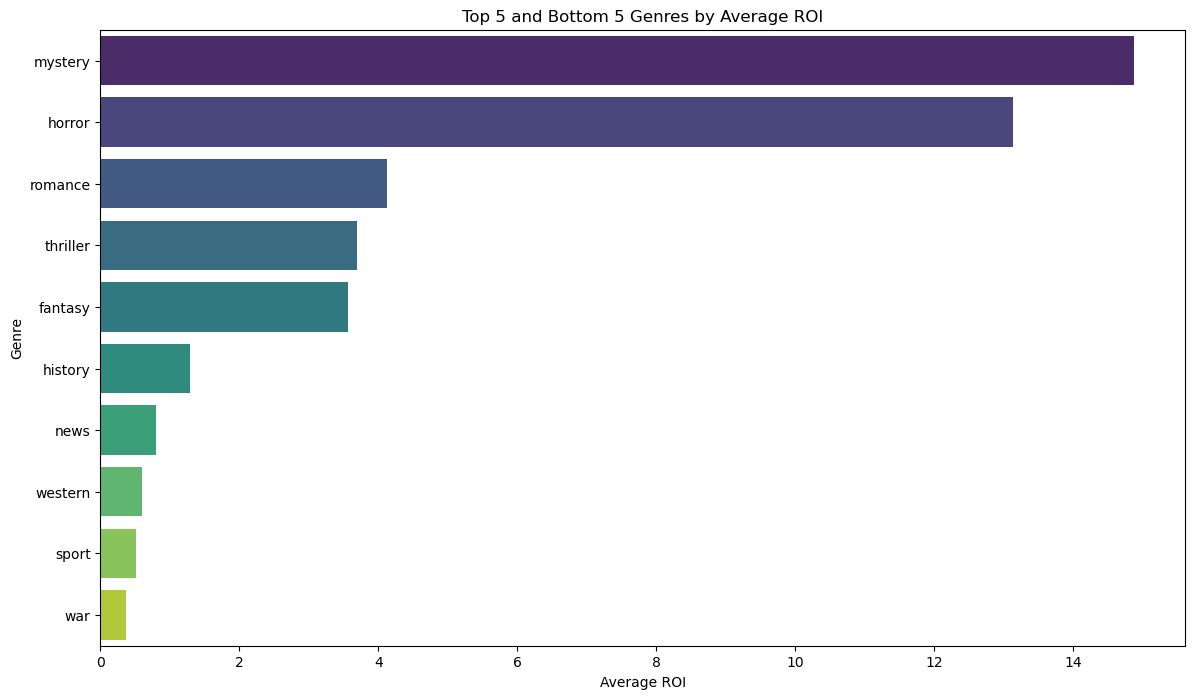

In [158]:
# explode the genres so each genre gets its own row
movie_df_exploded = df.explode('genres')

# calculate the average ROI for each genre
roi_by_genre = movie_df_exploded.groupby('genres')['roi'].mean().reset_index()

# sort the data by ROI
roi_by_genre_sorted = roi_by_genre.sort_values(by='roi', ascending=False)

# select the top 5 and bottom 5 genres
top_5_genres = roi_by_genre_sorted.head(5)
bottom_5_genres = roi_by_genre_sorted.tail(5)

# combine the top and bottom 5 genres
selected_genres = pd.concat([top_5_genres, bottom_5_genres])

# create the bar chart using seaborn
plt.figure(figsize=(14, 8))
sns.barplot(x='roi', y='genres', data=selected_genres, palette='viridis')
plt.title('Top 5 and Bottom 5 Genres by Average ROI')
plt.xlabel('Average ROI')
plt.ylabel('Genre')
plt.show()

/var/folders/zp/h7t69w7n1jvg_7vxjttlw77c0000gn/T/ipykernel_47396/3491240490.py:19: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




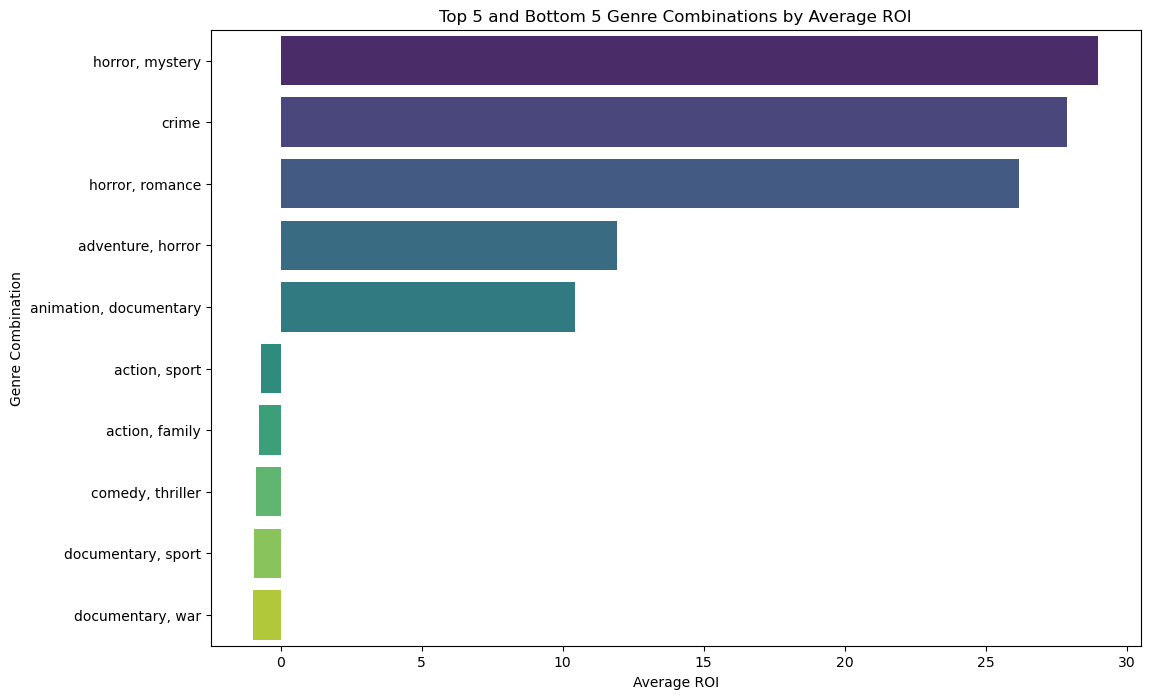

In [159]:
# convert the genres column from lists to strings
df['genres'] = df['genres'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)

# group by Genre Combinations and Calculate Average ROI
roi_by_genre_combination = df.groupby('genres')['roi'].mean().reset_index()

# sort the Combinations by ROI
roi_by_genre_combination = roi_by_genre_combination.sort_values(by='roi', ascending=False)

# select the Top 5 and Bottom 5 Genre Combinations
top_5_genres = roi_by_genre_combination.head(5)
bottom_5_genres = roi_by_genre_combination.tail(5)

# combine the top and bottom 5
selected_genres = pd.concat([top_5_genres, bottom_5_genres])

# visualize the results
plt.figure(figsize=(12, 8))
sns.barplot(x='roi', y='genres', data=selected_genres, palette='viridis')
plt.title('Top 5 and Bottom 5 Genre Combinations by Average ROI')
plt.xlabel('Average ROI')
plt.ylabel('Genre Combination')
plt.show()

#### Findings
- The genres with the highest ROI are:
    1. Horror/Mystery
    2. Crime
    3. Horror/Romance
    4. Adventure/Horror
    5. Animation/Documentary
- The genres with the lowest ROI are:
    1. Action/Sport
    2. Action/Family
    3. Comedy/Thriller
    4. Documentary/Sport
    5. Documentary/War

Note that these findings are also supported by the previous analysis of Individual Genres

### Analysis of Runtime
- Consider the relationship between runtime and ROI

/var/folders/zp/h7t69w7n1jvg_7vxjttlw77c0000gn/T/ipykernel_47396/711865534.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/zp/h7t69w7n1jvg_7vxjttlw77c0000gn/T/ipykernel_47396/711865534.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




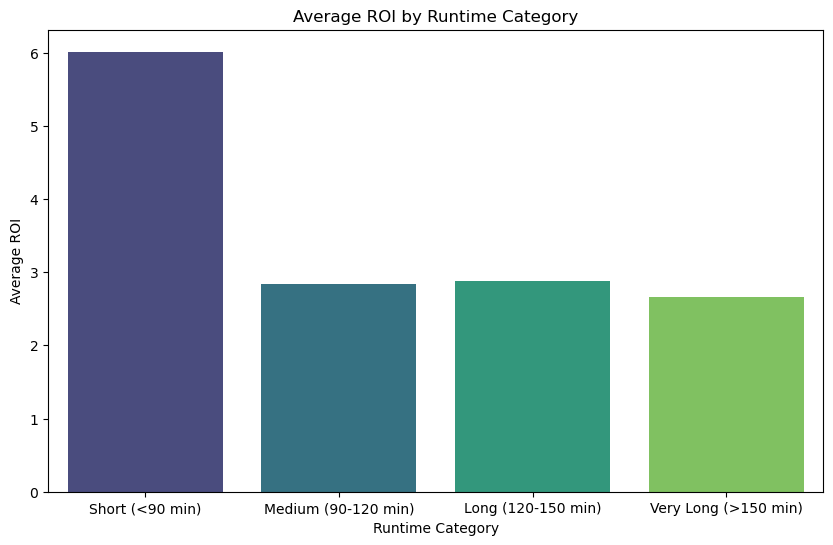

In [160]:
# bin runtimes into categories
bins = [0, 90, 120, 150, float('inf')]  # Define the bins (e.g., Short <90min, Medium 90-120min, Long >120min)
labels = ['Short (<90 min)', 'Medium (90-120 min)', 'Long (120-150 min)', 'Very Long (>150 min)']
df['runtime_category'] = pd.cut(df['runtime_minutes'], bins=bins, labels=labels, right=False)

# calculate the ROI for each runtime category
roi_by_runtime_category = df.groupby('runtime_category')['roi'].mean().reset_index()

# plot the results
plt.figure(figsize=(10, 6))
sns.barplot(x='runtime_category', y='roi', data=roi_by_runtime_category, palette='viridis')
plt.title('Average ROI by Runtime Category')
plt.xlabel('Runtime Category')
plt.ylabel('Average ROI')
plt.show()

#### Findings
- Shorter movies tend to have higher ROI

### Analysis of Reviews
- Consider the relationship between reviews and ROI

/var/folders/zp/h7t69w7n1jvg_7vxjttlw77c0000gn/T/ipykernel_47396/2048359388.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




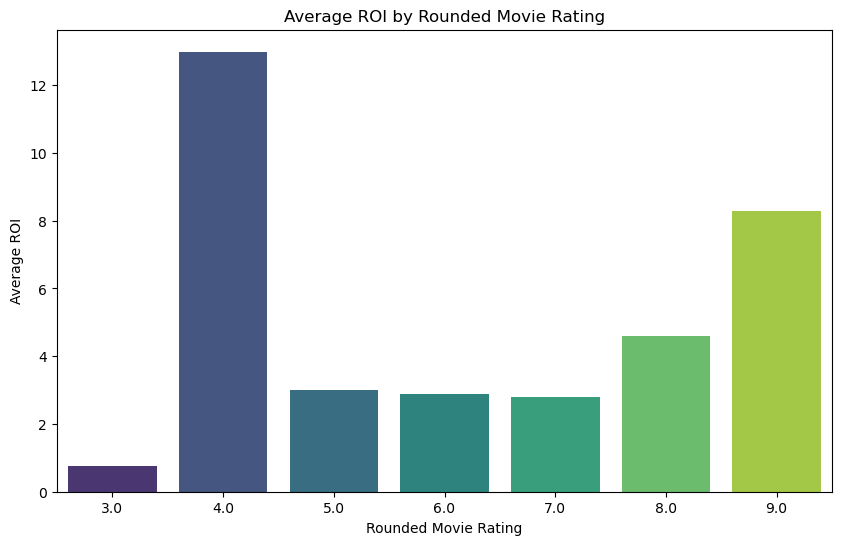

In [161]:
# Step 1: Round the Ratings to the Nearest Integer
df['rounded_rating'] = df['rating'].round()

# Step 2: Calculate the Average ROI for Each Rounded Rating
roi_by_rounded_rating = df.groupby('rounded_rating')['roi'].mean().reset_index()

# Step 3: Create the Bar Chart
plt.figure(figsize=(10, 6))
sns.barplot(x='rounded_rating', y='roi', data=roi_by_rounded_rating, palette='viridis')
plt.title('Average ROI by Rounded Movie Rating')
plt.xlabel('Rounded Movie Rating')
plt.ylabel('Average ROI')
plt.show()

#### Findings
- There is a positive correlation between weak reviews and high ROI 

### Analysis of Studios
- Consider the relationship between studios and ROI

/var/folders/zp/h7t69w7n1jvg_7vxjttlw77c0000gn/T/ipykernel_47396/1200728913.py:16: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




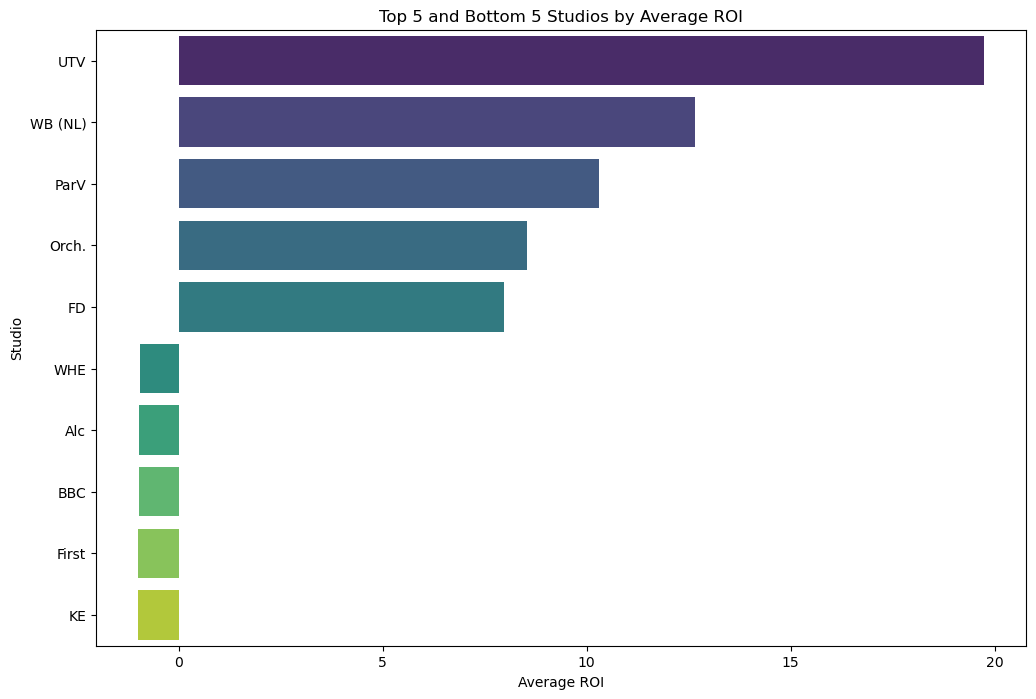

In [162]:
# group by Studio and Calculate Average ROI
roi_by_studio = df.groupby('studio')['roi'].mean().reset_index()

# sort the Data by ROI
roi_by_studio = roi_by_studio.sort_values(by='roi', ascending=False)

# select Top 5 and Bottom 5 Studios
top_5_studios = roi_by_studio.head(5)
bottom_5_studios = roi_by_studio.tail(5)

# combine the top and bottom 5 into one DataFrame
top_bottom_studios = pd.concat([top_5_studios, bottom_5_studios])

# create the Bar Chart
plt.figure(figsize=(12, 8))
sns.barplot(x='roi', y='studio', data=top_bottom_studios, palette='viridis')
plt.title('Top 5 and Bottom 5 Studios by Average ROI')
plt.xlabel('Average ROI')
plt.ylabel('Studio')
plt.show()

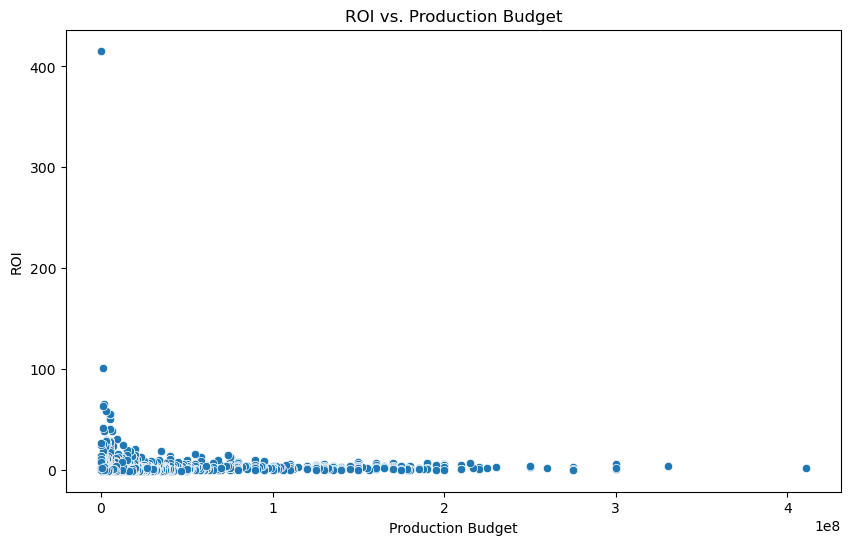

Correlation between Production Budget and ROI: -0.08


/var/folders/zp/h7t69w7n1jvg_7vxjttlw77c0000gn/T/ipykernel_47396/1815147737.py:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




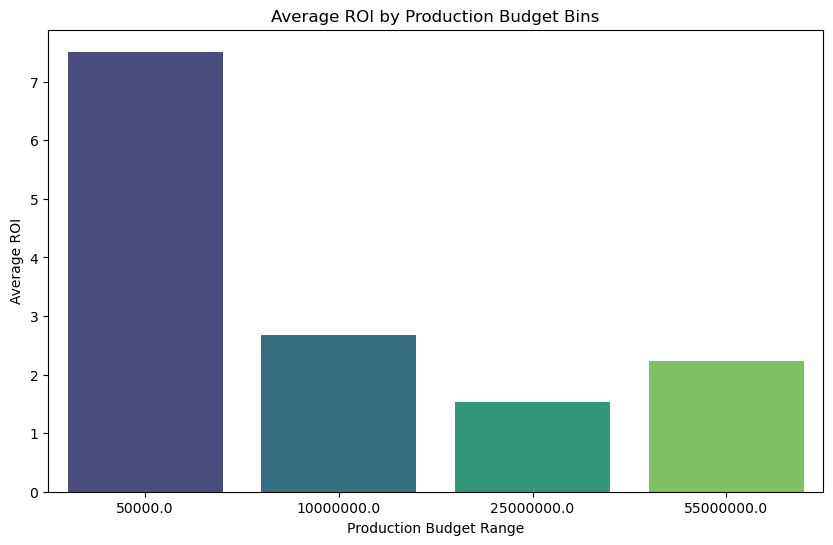

                            OLS Regression Results                            
Dep. Variable:                    roi   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     9.325
Date:                Mon, 12 Aug 2024   Prob (F-statistic):            0.00230
Time:                        04:20:34   Log-Likelihood:                -6234.0
No. Observations:                1582   AIC:                         1.247e+04
Df Residuals:                    1580   BIC:                         1.248e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.1629      0.40

In [163]:
# data preparation
df = df.replace([np.inf, -np.inf], np.nan)

# plot production budget vs. ROI
plt.figure(figsize=(10, 6))
sns.scatterplot(x='production_budget', y='roi', data=df)
plt.title('ROI vs. Production Budget')
plt.xlabel('Production Budget')
plt.ylabel('ROI')
plt.show()

# correlation analysis
correlation = df['production_budget'].corr(df['roi'])
print(f'Correlation between Production Budget and ROI: {correlation:.2f}')

# discretize the production_budget into bins
binner = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
df['budget_bin'] = binner.fit_transform(df[['production_budget']])

# analyze average ROI across different budget bins
roi_by_budget_bin = df.groupby('budget_bin')['roi'].mean().reset_index()
roi_by_budget_bin['budget_range'] = binner.bin_edges_[0][roi_by_budget_bin['budget_bin'].astype(int)]

plt.figure(figsize=(10, 6))
sns.barplot(x='budget_range', y='roi', data=roi_by_budget_bin, palette='viridis')
plt.title('Average ROI by Production Budget Bins')
plt.xlabel('Production Budget Range')
plt.ylabel('Average ROI')
plt.show()

# linear regression analysis
X = df[['production_budget']]
y = df['roi']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

#### Findings
Despite the low R-squared, the production budget is statistically significant with a p-value of 0.004, 
indicating that there is a relationship between production budget and ROI, even though it's weak.

### Correlation Matrix
- Create a correlation matrix to summarize the relationships between the various factors

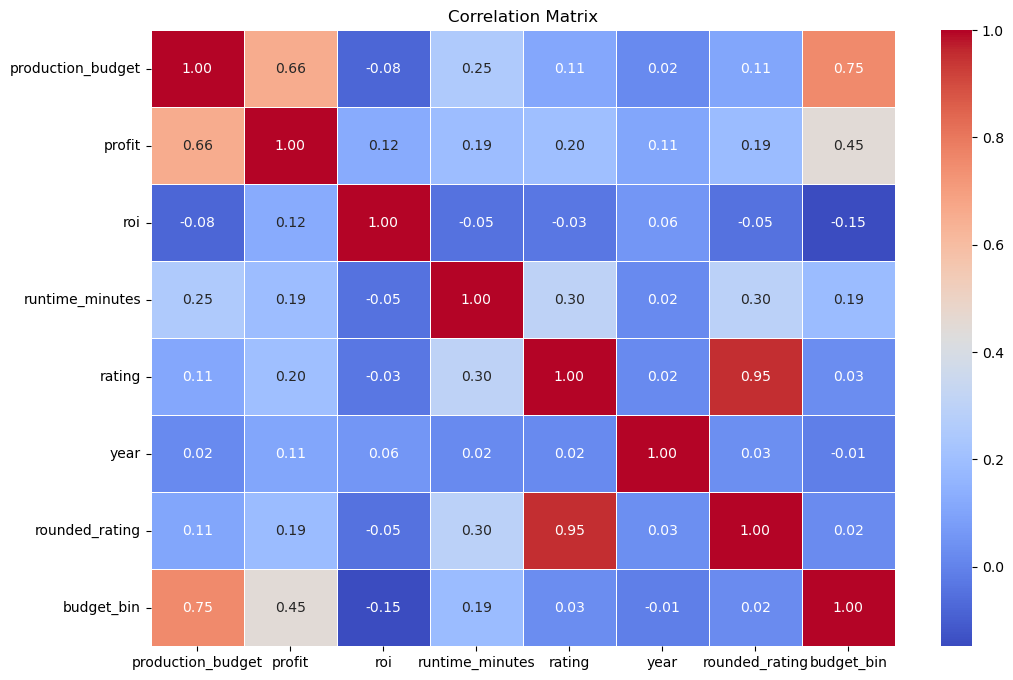

In [164]:
# Step 1: Select relevant numeric columns
numeric_cols = df.select_dtypes(include=[np.number])

# Step 2: Compute the correlation matrix
correlation_matrix = numeric_cols.corr()

# Step 3: Visualize the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

#### Findings
- The data is largely uncorrelated